In [1]:
from flask import Flask
from flask import Flask, jsonify, request
from flask_sqlalchemy import SQLAlchemy
from sqlalchemy import Column, Integer, String
import os
import sqlite3
from flask_marshmallow import Marshmallow
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

C:\Users\Dell5520\PycharmProjects\personal\infrastructure\venv\lib\site-packages\flask_marshmallow\__init__.py:26: UserWarning: Flask-SQLAlchemy integration requires marshmallow-sqlalchemy to be installed.
  warnings.warn(


In [2]:
# first example

app = Flask(__name__)

@app.route('/')
def home():
    return 'Welcome to my flask api home'

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2022 18:01:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2022 18:01:00] "GET /favicon.ico HTTP/1.1" 404 -


In [43]:
# second example
# send some csv data to a sqlite db
# use that data to query an api to get results

df = pd.read_csv('grav.csv') 
df

,Unnamed: 0,F,mass1,mass2,r
0,0,0.004642,2.865162e+06,6.473375e+06,516.401288
1,1,0.006260,4.144444e+06,6.505278e+06,536.124756
2,2,0.003026,9.316521e+06,4.593597e+06,971.530777
3,3,0.001121,1.301287e+06,6.605588e+06,715.532404
4,4,0.016082,9.009957e+06,5.195703e+06,440.769950
...,...,...,...,...,...
195,195,0.599997,6.335752e+06,8.362577e+06,76.769309
196,196,0.185663,5.494559e+06,8.732145e+06,131.327862
197,197,0.011454,9.357445e+06,8.365041e+06,675.335769
198,198,0.003349,9.602366e+06,3.757147e+06,847.950958


In [44]:
df = df.rename({'Unnamed: 0':'id'}, axis=1)
df.columns = [col.lower() for col in df.columns]
df

,id,f,mass1,mass2,r
0,0,0.004642,2.865162e+06,6.473375e+06,516.401288
1,1,0.006260,4.144444e+06,6.505278e+06,536.124756
2,2,0.003026,9.316521e+06,4.593597e+06,971.530777
3,3,0.001121,1.301287e+06,6.605588e+06,715.532404
4,4,0.016082,9.009957e+06,5.195703e+06,440.769950
...,...,...,...,...,...
195,195,0.599997,6.335752e+06,8.362577e+06,76.769309
196,196,0.185663,5.494559e+06,8.732145e+06,131.327862
197,197,0.011454,9.357445e+06,8.365041e+06,675.335769
198,198,0.003349,9.602366e+06,3.757147e+06,847.950958


In [2]:
def create_connection(db_file):
    """ 
    create a database connection to the SQLite database specified by db_file.
    
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Exception as e:
        print(e)

    return conn

In [46]:
database = 'flask.db'
table = 'grav'

with create_connection(database) as conn:

    df.to_sql(table, conn, index=False, if_exists='replace')

In [47]:
flask_cols = tuple(df.columns)
flask_cols

('id', 'f', 'mass1', 'mass2', 'r')

In [48]:
app = Flask(__name__)
base_dir = os.path.abspath('.')
db_path = os.path.join(base_dir, database)

app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///' + db_path

db = SQLAlchemy(app)
ma = Marshmallow(app)

@app.route('/')
def home():
    return jsonify(data='Welcome to my flask api home - Alex')

@app.route('/get_measurements')
def get_measurements():
    
    con = request.args.get('id', 'unknown')
    by_stream = request.args.get('stream', 'unknown')
    
    if by_stream != 'unknown':
        con_details = Consultant.query.filter_by(stream=by_stream).all()
        result = consultant_schemas.dump(con_details)
        
    else:
        con_details = Consultant.query.filter_by(id=con).first()
        result = consultant_schema.dump(con_details)
        
    return jsonify(result)

class Consultant(db.Model):
    
    __tablename__ = table
    
    id = Column(Integer, primary_key=True)
    f = Column(String)
    mass1 = Column(String)
    mass2 = Column(String)
    r = Column(String)

class ConsultantSchema(ma.Schema):
    class Meta:
        fields = flask_cols

In [49]:
consultant_schema = ConsultantSchema()

consultant_schemas = ConsultantSchema(many=True)

# python scripts have the value '__main__' when being executed (not imported)

# TO TEST
# To my welcome message: http://127.0.0.1:5000/
# To see a single record: http://127.0.0.1:5000/get_measurements?id=0 in browser

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2022 19:15:44] "GET /get_measurements?f=0.004642 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2022 19:15:45] "GET /get_measurements?f=0.004642 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2022 19:15:52] "GET /get_measurements?id=0 HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2022 19:18:25] "GET /get_measurements?id=0,1 HTTP/1.1" 200 -


In [3]:
# third example
# create a ML model and serve through an api where you can get real-time predictions


database = 'flask.db'
table = 'grav'

with create_connection(database) as conn:

    df = pd.read_sql(f"SELECT * FROM {table}", conn)

df

,id,f,mass1,mass2,r
0,0,0.004642,2.865162e+06,6.473375e+06,516.401288
1,1,0.006260,4.144444e+06,6.505278e+06,536.124756
2,2,0.003026,9.316521e+06,4.593597e+06,971.530777
3,3,0.001121,1.301287e+06,6.605588e+06,715.532404
4,4,0.016082,9.009957e+06,5.195703e+06,440.769950
...,...,...,...,...,...
195,195,0.599997,6.335752e+06,8.362577e+06,76.769309
196,196,0.185663,5.494559e+06,8.732145e+06,131.327862
197,197,0.011454,9.357445e+06,8.365041e+06,675.335769
198,198,0.003349,9.602366e+06,3.757147e+06,847.950958


In [4]:
# create classification target column

df['is_huge'] = np.where(df['r'] > 900, 1, 0)
df

,id,f,mass1,mass2,r,is_huge
0,0,0.004642,2.865162e+06,6.473375e+06,516.401288,0
1,1,0.006260,4.144444e+06,6.505278e+06,536.124756,0
2,2,0.003026,9.316521e+06,4.593597e+06,971.530777,1
3,3,0.001121,1.301287e+06,6.605588e+06,715.532404,0
4,4,0.016082,9.009957e+06,5.195703e+06,440.769950,0
...,...,...,...,...,...,...
195,195,0.599997,6.335752e+06,8.362577e+06,76.769309,0
196,196,0.185663,5.494559e+06,8.732145e+06,131.327862,0
197,197,0.011454,9.357445e+06,8.365041e+06,675.335769,0
198,198,0.003349,9.602366e+06,3.757147e+06,847.950958,0


accuracy (test):  1.0


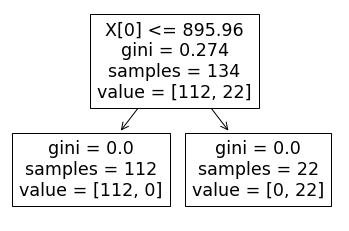

In [5]:
# prepare data
y = df['is_huge']
X = df.drop(columns=['id', 'is_huge', 'mass1', 'mass2', 'f'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Model fitting
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Model evaluation
y_hat = model.predict(X_test)
acc   = accuracy_score(y_test, y_hat)
print('accuracy (test): ', acc)

# Plotting
plot_tree(model)

# Pickling File 
file_name = r'saved_model'
saved_model = pickle.dump(model, open(file_name, 'wb'))

In [11]:
app = Flask(__name__)
base_dir = os.path.abspath('.')
model_path = 'saved_model'

@app.route('/')
def home():
    return jsonify(data='Enter your r value')


model = pickle.load(open(model_path, 'rb'))

@app.route('/r_pred')
def get_pred():

    r = float(request.args.get('r', 'unknown'))

    if r != 'unknown':

        pred = model.predict(np.array((r)).reshape(1, -1))[0]
        
        if pred == 0:
            resp = 'Not big enough'
        else:
            resp = 'You are huge'
    else:

        pred = 'Not enough info'
        resp = '-'
    
    return jsonify(is_huge=float(pred), text=resp)

In [12]:
# TEST
# To my welcome message: http://127.0.0.1:5000/
# To get a too small response: http://127.0.0.1:5000/r_pred?r=100
# To get a big response: http://127.0.0.1:5000/r_pred?r=1000

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
C:\Users\Dell5520\PycharmProjects\personal\infrastructure\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
127.0.0.1 - - [05/Jun/2022 20:05:42] "GET /r_pred?r=100 HTTP/1.1" 200 -
C:\Users\Dell5520\PycharmProjects\personal\infrastructure\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
127.0.0.1 - - [05/Jun/2022 20:05:48] "GET /r_pred?r=1000 HTTP/1.1" 200 -
